In [325]:
library(QFASA)
library(dplyr)
library(ggplot2)
library(tidyr)

# Fatty acid names

In [3]:
fa.names = read.csv(file=system.file("exdata", "FAset.csv", package="QFASA"), as.is=TRUE)

# Predator fatty acid signatures

In [166]:
predators = read.csv(file=system.file("exdata", "predatorFAs.csv", package="QFASA"))

## Fatty acid distribution over predator samples

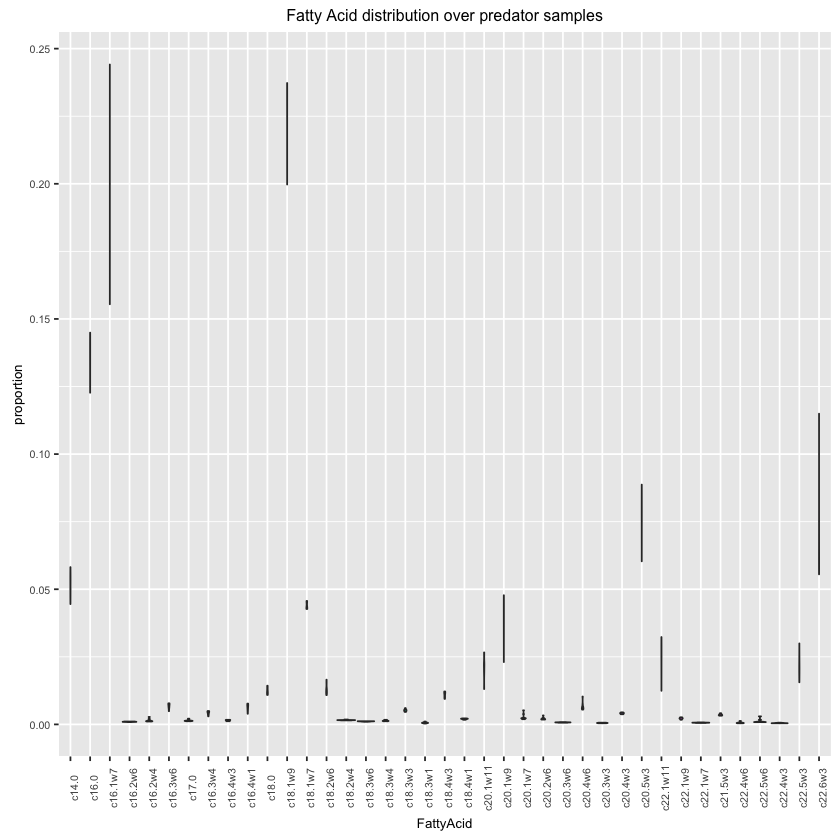

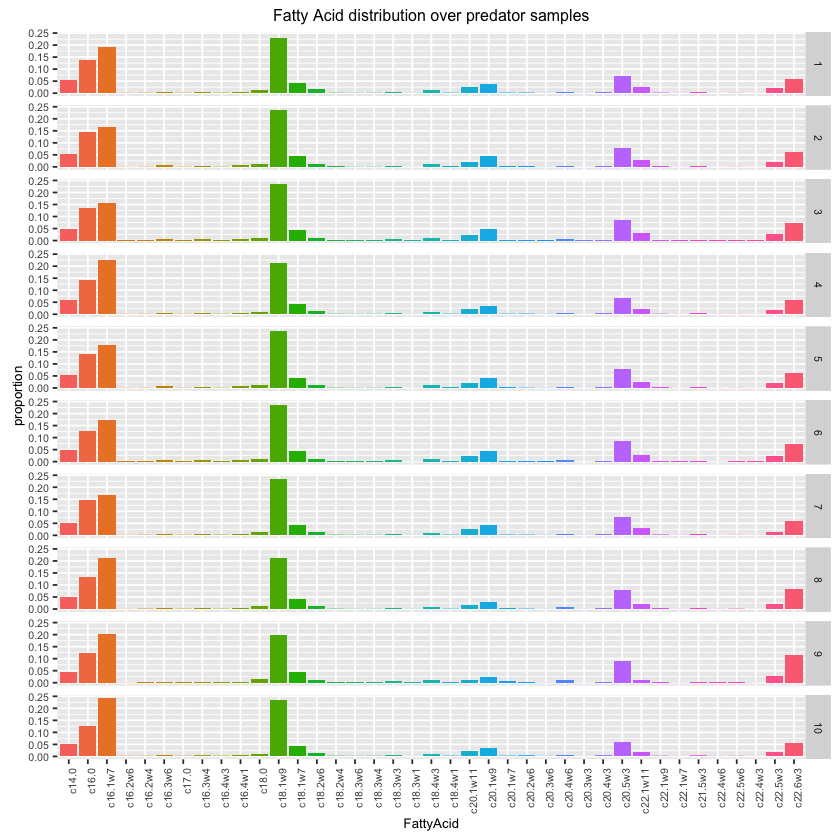

In [124]:
d <- predators %>% dplyr::select_(.dots = fa.names$FA) %>% 
    dplyr::mutate(id=row_number()) %>%
    tidyr::gather(FattyAcid, percentage, -id, factor_key=TRUE) %>%
    dplyr::group_by(id) %>% 
    dplyr::mutate(proportion=percentage/sum(percentage)) 
    
ggplot(data=d, aes(x=FattyAcid, y=proportion, fill=FattyAcid)) + 
    geom_violin() +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90)) + guides(fill=FALSE) + 
    ggtitle("Fatty Acid distribution over predator samples")
ggsave(file='predator_fa_species_violin.png', height=14, width=7)

ggplot(data=d, aes(x=FattyAcid, y=proportion, fill=FattyAcid)) + 
    geom_bar(stat='identity') +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90, hjust = 1)) + guides(fill=FALSE) + 
    facet_grid(id ~ .) +
    ggtitle("Fatty Acid distribution over predator samples")
ggsave(file='predator_fa_species_bar.png', height=14, width=7)

# Prey Fatty Acids

In [118]:
prey = read.csv(file=system.file("exdata", "preyFAs.csv", package="QFASA"))
prey <- prey %>% dplyr::select_('Species', .dots = fa.names$FA) %>%
    dplyr::mutate(id=row_number())

## Fatty Acid Distribution over prey samples

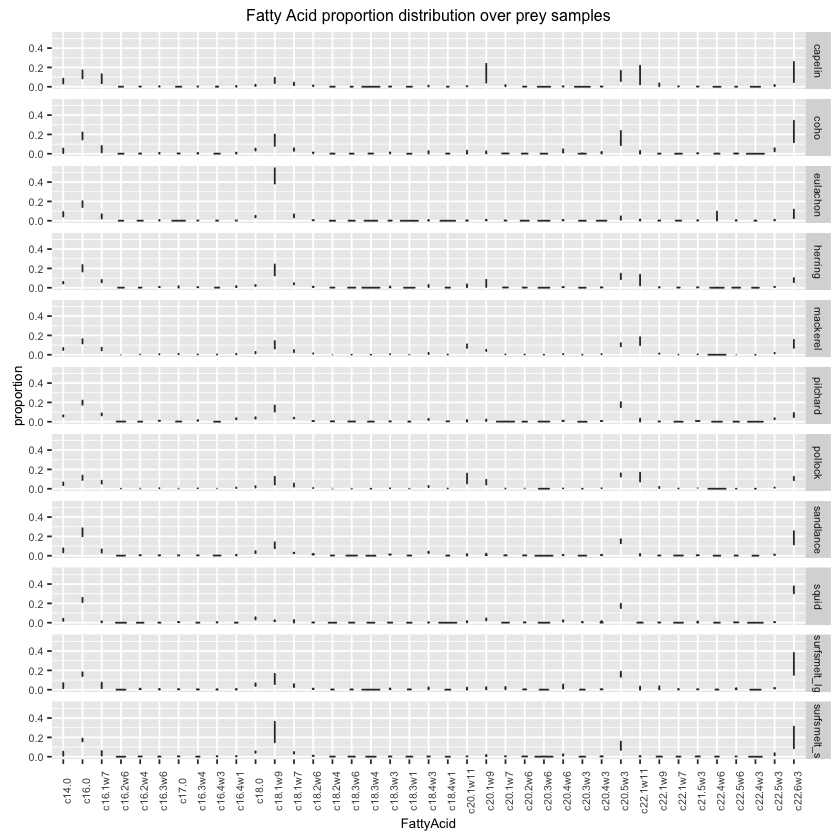

In [122]:
d <- prey %>% 
    tidyr::gather(FattyAcid, proportion, -id, -Species, factor_key=TRUE) %>%
    dplyr::group_by(id) %>% 
    dplyr::mutate(proportion=proportion/sum(proportion)) 

ggplot(data=d, aes(x=FattyAcid, y=proportion, fill=FattyAcid)) + 
    geom_violin() +
    facet_grid(Species ~ .) +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90)) + guides(fill=FALSE) + 
    ggtitle("Fatty Acid proportion distribution over prey samples")
ggsave(file='prey_fa_species_violin.png', height=14, width=7)

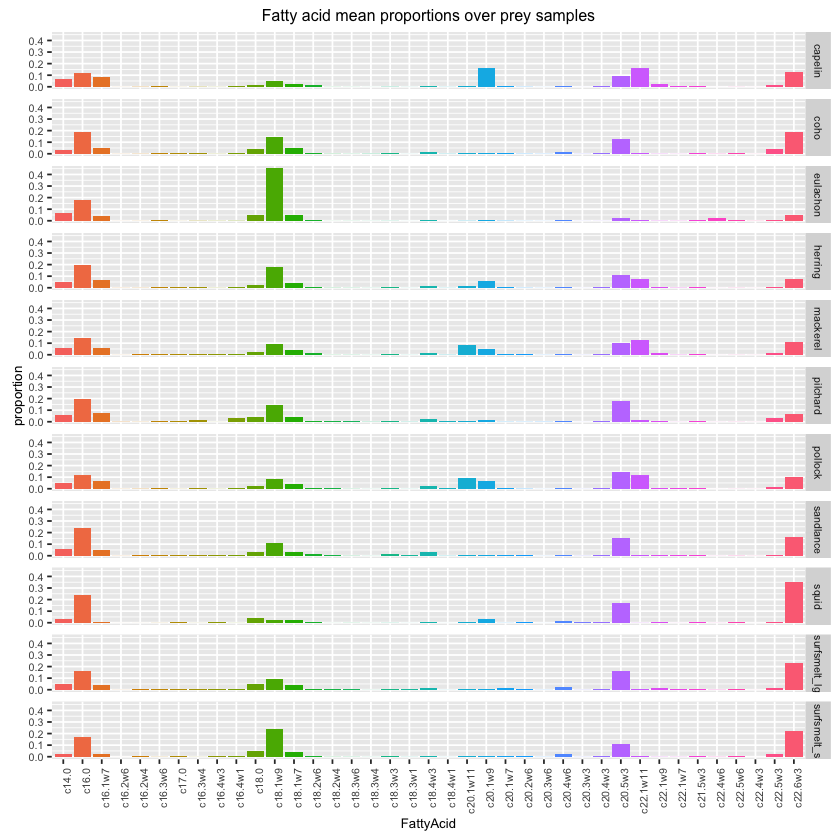

In [123]:
d <- prey %>% 
    tidyr::gather(FattyAcid, proportion, -id, -Species, factor_key=TRUE) %>%
    dplyr::group_by(id) %>% 
    dplyr::mutate(proportion=proportion/sum(proportion)) %>% 
    dplyr::group_by(Species, FattyAcid) %>%
    dplyr::summarize(proportion=mean(proportion))

ggplot(data=d, aes(x=FattyAcid, y=proportion, fill=FattyAcid)) + 
    geom_bar(stat='identity') +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90, hjust = 1)) + guides(fill=FALSE) + 
    facet_grid(Species ~ .) +
    ggtitle("Fatty acid mean proportions over prey samples")
ggsave(file='prey_fa_species_bar.png', height=14, width=7)

# Calibration Coefficents

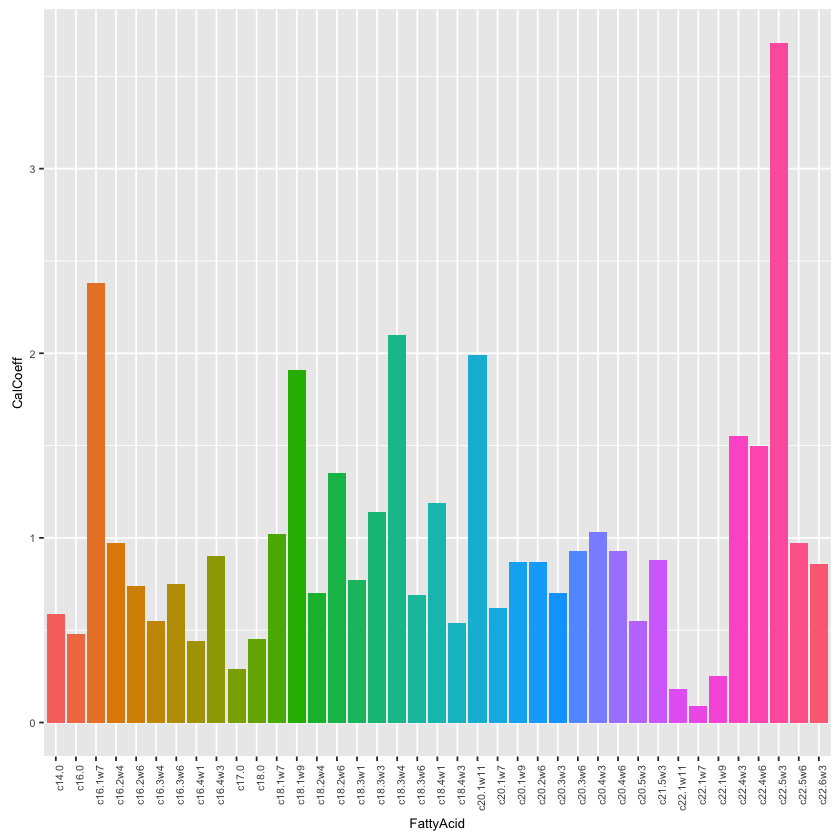

In [303]:
cal = read.csv(file=system.file("exdata", "CC.csv", package="QFASA"), as.is=TRUE)
cal <- cal %>% dplyr::filter(FA %in% fa.names$FA) %>%
    transmute(FattyAcid = as.factor(FA), CalCoeff = CC)

ggplot(data=cal, aes(x=FattyAcid, y=CalCoeff, fill=FattyAcid)) + 
    geom_bar(stat='identity') +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90, hjust = 1)) +
    guides(fill=FALSE)
    

# Calibration coefficents are the same for all predators in same group (species)
cal.mat = replicate(dim(predators)[1], cal$CalCoeff)

## Run model

In [247]:
predators = read.csv(file=system.file("exdata", "predatorFAs.csv", package="QFASA")) %>%
    dplyr::select_(.dots = fa.names$FA) %>% 
    dplyr::mutate(id=row_number()) %>%
    tidyr::gather(FattyAcid, percentage, -id, factor_key=TRUE) %>%
    dplyr::group_by(id) %>% 
    dplyr::mutate(percentage=percentage/sum(percentage)) %>%
    tidyr::spread(FattyAcid, percentage) %>% 
    dplyr::ungroup() %>%
    dplyr::select(-id)

In [257]:
prey <- read.csv(file=system.file("exdata", "preyFAs.csv", package="QFASA")) %>%
    dplyr::select_('Species', .dots = fa.names$FA) %>% # filter fatty acids
    dplyr::mutate(id=row_number()) %>%  # add a row id for sample grouping in long format
    tidyr::gather(FattyAcid, proportion, -id, -Species, factor_key=TRUE) %>% 
    dplyr::group_by(id) %>% 
    dplyr::mutate(proportion=proportion/sum(proportion)) %>% # normalize sample proportions 
    dplyr::group_by(Species, FattyAcid) %>% 
    dplyr::summarize(proportion=mean(proportion)) %>% # average sample proportions
    tidyr::spread(FattyAcid, proportion)

In [258]:
# Account for fat content of prey species
FC <- read.csv(file=system.file("exdata", "preyFAs.csv", package="QFASA")) %>%
    dplyr::select(Species, lipid) %>%
    dplyr::group_by(Species) %>%
    dplyr::summarize(lipid=mean(lipid))

## Diet Estimates

In [293]:
QFASA.KL = p.QFASA(as.matrix(predators), 
                as.matrix(prey %>% dplyr::ungroup() %>% dplyr::select(-Species)), 
                cal.mat, 
                dist.meas=1,# KL
                gamma=1, 
                FC$lipid, 
                start.val=rep(1, dim(prey)[1]), 
                fa.names$FA)

DietEst = QFASA.KL$'Diet Estimates'
colnames(DietEst) = prey$Species
DietEst.KL <- data.frame(DietEst, dist='KL')

In [294]:
QFASA.AIT = p.QFASA(as.matrix(predators), 
                as.matrix(prey %>% dplyr::ungroup() %>% dplyr::select(-Species)), 
                cal.mat, 
                dist.meas=2, # AIT
                gamma=1, 
                FC$lipid, 
                start.val=rep(1, dim(prey)[1]), 
                fa.names$FA)

DietEst = QFASA.AIT$'Diet Estimates'
colnames(DietEst) = prey$Species
DietEst.AIT <- data.frame(DietEst, dist='AIT')

In [295]:
QFASA.CS = p.QFASA(as.matrix(predators), 
                as.matrix(prey %>% dplyr::ungroup() %>% dplyr::select(-Species)), 
                cal.mat, 
                dist.meas=3,# CS
                gamma=1, 
                FC$lipid, 
                start.val=rep(1, dim(prey)[1]), 
                fa.names$FA)

DietEst = QFASA.CS$'Diet Estimates'
colnames(DietEst) = prey$Species
DietEst.CS <- data.frame(DietEst, dist='CS')

Warning message:
In rbind_list__impl(environment()): Unequal factor levels: coercing to character

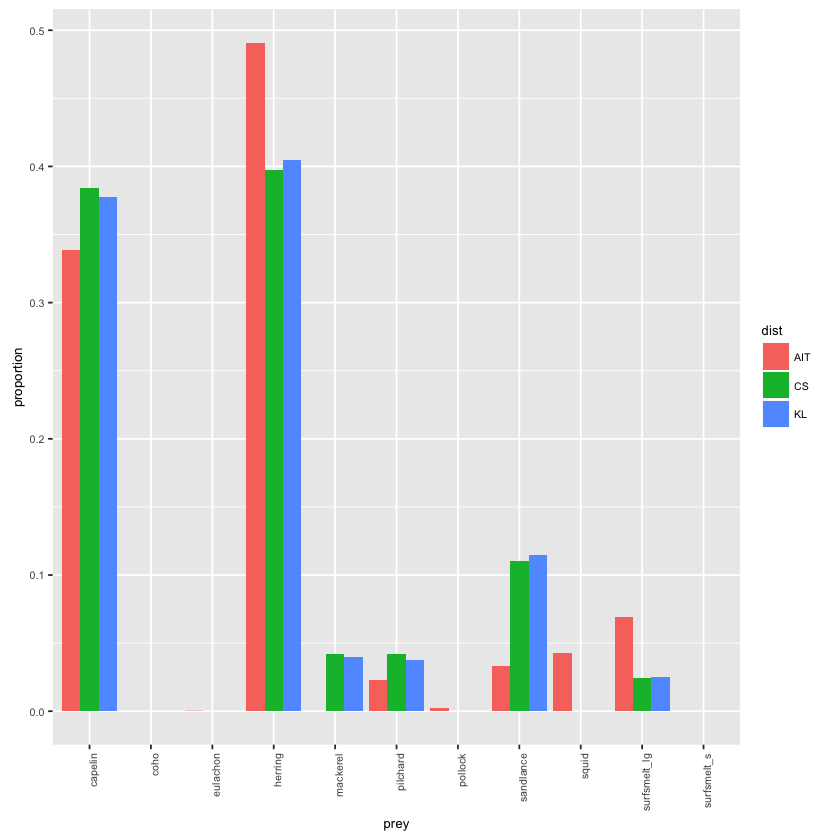

In [323]:
DietEst <- dplyr::rbind_list(DietEst.KL, DietEst.AIT, DietEst.CS) %>%
    tidyr::gather(prey, proportion, -dist) %>%
    dplyr::mutate(dist=as.factor(dist), prey=as.factor(prey)) %>%
    dplyr::group_by(dist, prey) %>%
    dplyr::summarize(proportion=mean(proportion)) %>%
    dplyr::ungroup()
    
ggplot(data=DietEst, aes(x=prey, y=proportion, fill=dist)) + geom_bar(stat='identity', position='dodge') +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90, hjust = 1))

## Additional Measures

In [318]:
Add.meas.KL = plyr::ldply(QFASA.KL$'Additional Measures', data.frame) %>% 
    dplyr::select(contains('ModFAS')) %>%
    dplyr::mutate(dist='KL')
    
Add.meas.AIT = plyr::ldply(QFASA.AIT$'Additional Measures', data.frame) %>% 
    dplyr::select(contains('ModFAS')) %>%
    dplyr::mutate(dist='AIT')

Add.meas.CS = plyr::ldply(QFASA.CS$'Additional Measures', data.frame) %>% 
    dplyr::select(contains('ModFAS')) %>%
    dplyr::mutate(dist='CS')

Add.meas <- dplyr::rbind_list(Add.meas.KL, Add.meas.AIT, Add.meas.CS) %>%
    dplyr::mutate(dist=as.factor(dist)) %>%
    tidyr::gather(ModFAS, proportion, -dist, factor_key=TRUE) %>%
    dplyr::group_by(dist, ModFAS) %>%
    dplyr::summarize(proportion=mean(proportion)) %>%
    dplyr::ungroup()


str(Add.meas)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	117 obs. of  3 variables:
 $ dist      : Factor w/ 3 levels "AIT","CS","KL": 1 1 1 1 1 1 1 1 1 1 ...
 $ ModFAS    : Factor w/ 39 levels "ModFAS.c14.0",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ proportion: num  0.053464 0.187457 0.069697 0.000955 0.001767 ...


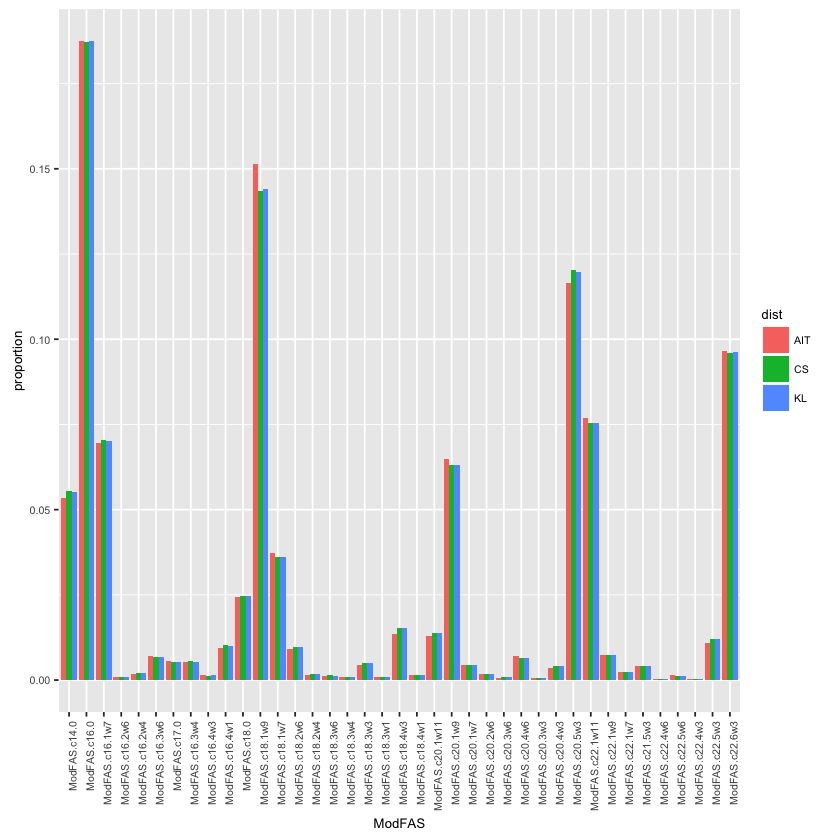

In [320]:
ggplot(data=Add.meas, aes(x=ModFAS, y=proportion, fill=dist)) + 
    geom_bar(stat='identity', position='dodge') +
    theme(text=element_text(size=8), axis.text.x  = element_text(angle=90, hjust = 1))